Importations et Définitions de la Fonction Quadratique

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize_scalar

# 2. Quadratique
def f_quad(v):
    x, y = v
    return x**2 - y**2

def grad_quad(v):
    x, y = v
    df_dx = 2 * x
    df_dy = -2 * y
    return np.array([df_dx, df_dy])

Implémentation des Algorithmes

In [2]:
def gradient_pas_fixe(f, grad_f, x0, rho=0.001, max_iter=1000, tol=1e-6):
    x = np.array(x0, dtype=float)
    history = [] 
    
    # Enregistrement du point initial
    history.append({
        'k': 0,
        'x': x[0],
        'y': x[1],
        'f(x,y)': f(x),
        '||grad f||': np.linalg.norm(grad_f(x)),
        's_k': 0.0
    })
    
    for k in range(1, max_iter + 1):
        g = grad_f(x)
        norm_g = np.linalg.norm(g)
        
        if norm_g < tol:
            break
        
        # Mise à jour
        x = x - rho * g
        val = f(x)
        
        # Enregistrement
        history.append({
            'k': k,
            'x': x[0],
            'y': x[1],
            'f(x,y)': val,
            '||grad f||': norm_g,
            's_k': rho
        })
        
    
    return pd.DataFrame(history)

def gradient_pas_optimal(f, grad_f, x0, max_iter=1000, tol=1e-6):
    x = np.array(x0, dtype=float)
    history = []
    
    # Point initial
    history.append({
        'k': 0,
        'x': x[0],
        'y': x[1],
        'f(x,y)': f(x),
        '||grad f||': np.linalg.norm(grad_f(x)),
        's_k': 0.0
    })
    
    for k in range(1, max_iter + 1):
        g = grad_f(x)
        norm_g = np.linalg.norm(g)
        
        if norm_g < tol:
            break
            
        d = -g
        
        def phi(s):
            return f(x + s * d)
        
        # Recherche linéaire
        res = minimize_scalar(phi, bounds=(0, 2), method='bounded')
        s_k = res.x
        
        x = x + s_k * d
        val = f(x)
        
        history.append({
            'k': k,
            'x': x[0],
            'y': x[1],
            'f(x,y)': val,
            '||grad f||': norm_g, # Norme du gradient précédent
            's_k': s_k
        })
        
    
    return pd.DataFrame(history)

Expérimentation et Visualisation

In [5]:
def analyze_quad_safe(f, grad_f, x0, name, rho=0.001, x_bounds=(-2, 2), y_bounds=(-2, 2)):
    print(f"--- ANALYSE SÉCURISÉE : {name} ---")
    
    # On réduit max_iter car ça diverge très vite
    # On ajoute une tolérance de divergence (si norme > 100, on arrête)
    
    def gradient_pas_fixe_safe(f, grad_f, x0, rho, max_iter):
        x = np.array(x0, dtype=float)
        history = []
        for k in range(max_iter):
            history.append({'x': x[0], 'y': x[1], 'f(x,y)': f(x)})
            if np.max(np.abs(x)) > 100: # Sécurité anti-overflow
                break
            x = x - rho * grad_f(x)
        return pd.DataFrame(history)

    def gradient_pas_optimal_safe(f, grad_f, x0, max_iter):
        x = np.array(x0, dtype=float)
        history = []
        for k in range(max_iter):
            history.append({'x': x[0], 'y': x[1], 'f(x,y)': f(x)})
            if np.max(np.abs(x)) > 100: # Sécurité anti-overflow
                break
            
            g = grad_f(x)
            d = -g
            # On borne très court pour éviter le saut immédiat vers l'infini
            res = minimize_scalar(lambda s: f(x + s*d), bounds=(0, 0.5), method='bounded')
            x = x + res.x * d
        return pd.DataFrame(history)

    # 1. Exécution (avec moins d'itérations pour éviter le crash)
    df_fixe = gradient_pas_fixe_safe(f, grad_f, x0, rho, max_iter=50)
    df_opt = gradient_pas_optimal_safe(f, grad_f, x0, max_iter=50)

    # 2. Graphique avec LIMITES FIXES
    x = np.linspace(x_bounds[0], x_bounds[1], 400)
    y = np.linspace(y_bounds[0], y_bounds[1], 400)
    X, Y = np.meshgrid(x, y)
    Z = X**2 - Y**2 # Calcul direct vectorisé pour éviter les erreurs de boucle
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot Pas Fixe
    axes[0].contour(X, Y, Z, levels=50, cmap='viridis')
    axes[0].plot(df_fixe['x'], df_fixe['y'], 'r.-', label='Trajectoire')
    axes[0].plot(x0[0], x0[1], 'ko', label='Départ')
    # IMPORTANT : On force les limites de la vue
    axes[0].set_xlim(x_bounds)
    axes[0].set_ylim(y_bounds)
    axes[0].set_title(f"{name} - Pas Fixe")
    
    # Plot Pas Optimal
    axes[1].contour(X, Y, Z, levels=50, cmap='viridis')
    axes[1].plot(df_opt['x'], df_opt['y'], 'm.-', label='Trajectoire')
    axes[1].plot(x0[0], x0[1], 'ko', label='Départ')
    # IMPORTANT : On force les limites de la vue
    axes[1].set_xlim(x_bounds)
    axes[1].set_ylim(y_bounds)
    axes[1].set_title(f"{name} - Pas Optimal")
    
    plt.show()
    
    print("Dernières positions atteintes (montre la divergence) :")
    print("Pas Fixe :", df_fixe.iloc[-1][['x', 'y']].to_dict())
    print("Pas Optimal :", df_opt.iloc[-1][['x', 'y']].to_dict())

Lancement de l'algorithme

## Justification Mathématique du Point Initial $x_0 = (0.1, 0.1)$

La fonction quadratique étudiée est :
$$f(x,y) = x^2 - y^2$$

Cette fonction ne possède pas de minimum global, car elle n'est pas bornée inférieurement (elle tend vers $-\infty$ quand $|y| \to \infty$).

**Analyse de cette fonction :**
Le gradient est $\nabla f(x,y) = (2x, -2y)^T$. L'unique point stationnaire est l'origine $(0,0)$.
La matrice Hessienne est constante :
$$
H_f = \begin{pmatrix} 2 & 0 \\ 0 & -2 \end{pmatrix}
$$
Les valeurs propres sont $\lambda_1 = 2$ et $\lambda_2 = -2$.
* Puisque $\lambda_1 > 0$, la fonction est convexe (courbure vers le haut) selon l'axe $x$.
* Puisque $\lambda_2 < 0$, la fonction est concave (courbure vers le bas) selon l'axe $y$.
L'origine est donc un **point selle**.
**Pourquoi ce choix de $x_0$ ?**
* **Pourquoi pas $(0,0)$ ?** C'est un point stationnaire ($\nabla f = 0$). L'algorithme s'arrêterait immédiatement sans rien faire.
* **Pourquoi pas $(1, 0)$ ?** Sur l'axe $x$, la dérivée en $y$ est nulle ($-2y = 0$). L'algorithme resterait piégé sur la ligne de crête $y=0$ et convergerait à tort vers $(0,0)$.
* **Choix de $(0.1, 0.1)$ :** Nous introduisons une perturbation sur $y$. Le gradient en $y$ devenant négatif ($-0.2$), l'algorithme va "dévaler" la pente des $y$, illustrant ainsi correctement que la fonction diverge vers $-\infty$.

--- ANALYSE SÉCURISÉE : Quadratique (Divergence) ---


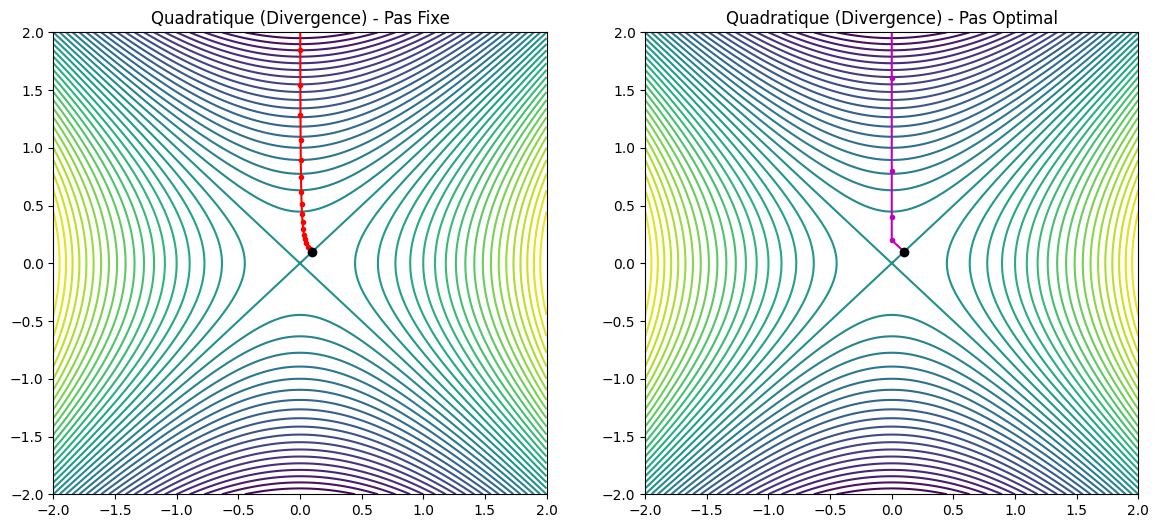

Dernières positions atteintes (montre la divergence) :
Pas Fixe : {'x': 2.076918743413932e-05, 'y': 102.06746999785322}
Pas Optimal : {'x': 3.2041390728830483e-52, 'y': 102.39543088197618}


In [6]:
analyze_quad_safe(f_quad, grad_quad, x0=[0.1, 0.1], name="Quadratique (Divergence)", rho=0.1)

Visualisation comparée des deux descentes de gradient

Visualisation pour la fonction Quadratique...


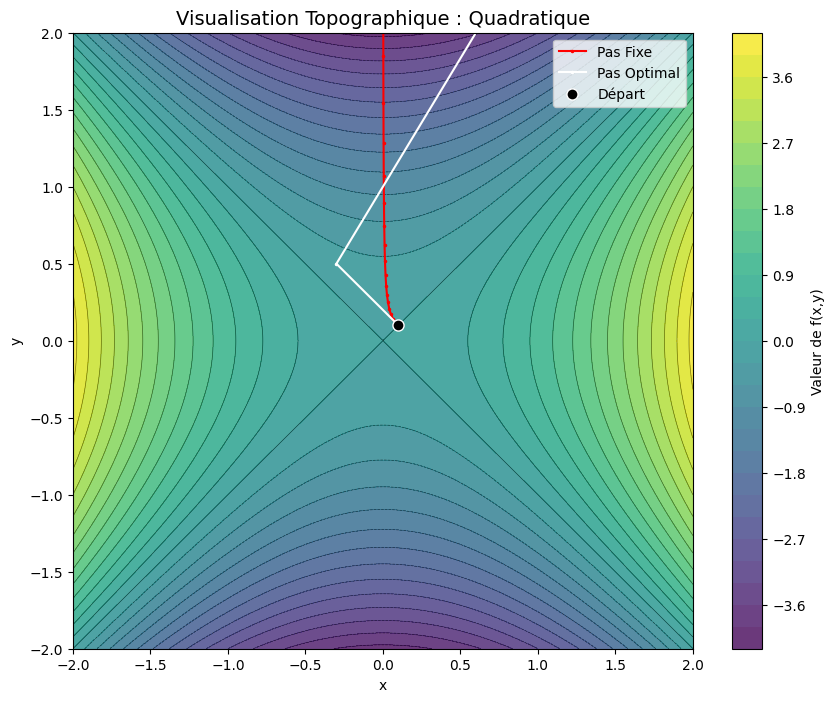

In [9]:
from matplotlib.colors import LogNorm
def visualiser_cuvette(f, path_fixe, path_opt, name, x_bounds, y_bounds, log_scale=False):
    """
    Visualisation améliorée pour voir l'effet 'Cuvette'.
    - Utilise contourf (remplissage) pour la profondeur.
    - Utilise une échelle Logarithmique si demandé (pour Rosenbrock).
    """
    x = np.linspace(x_bounds[0], x_bounds[1], 400)
    y = np.linspace(y_bounds[0], y_bounds[1], 400)
    X, Y = np.meshgrid(x, y)
    
    # Calcul de la grille
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = f([X[i, j], Y[i, j]])

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # --- ASTUCE : Échelle Logarithmique vs Linéaire ---
    if log_scale and Z.min() > 0:
        # Pour Rosenbrock, on utilise LogNorm pour bien voir le fond de la vallée
        # levels=np.logspace(...) crée des lignes exponentielles
        norm = LogNorm(vmin=Z.min(), vmax=Z.max())
        levels = np.logspace(np.log10(Z.min()), np.log10(Z.max()), 30)
    else:
        # Pour Quadratique et Himmelblau (qui ont des valeurs négatives ou 0)
        norm = None
        levels = 30

    # 1. Le fond coloré (La "Cuvette")
    # cmap='viridis' ou 'turbo' ou 'jet' donne un bon contraste profondeur
    cp = ax.contourf(X, Y, Z, levels=levels, norm=norm, cmap='viridis', alpha=0.8)
    fig.colorbar(cp, label='Valeur de f(x,y)')

    # 2. Les lignes de niveau (Les contours noirs)
    ax.contour(X, Y, Z, levels=levels, norm=norm, colors='black', linewidths=0.5, alpha=0.5)

    # 3. Les trajectoires
    ax.plot(path_fixe['x'], path_fixe['y'], 'r.-', markersize=3, label='Pas Fixe', linewidth=1.5)
    ax.plot(path_opt['x'], path_opt['y'], 'w.-', markersize=3, label='Pas Optimal', linewidth=1.5)
    
    # Points de départ et fin
    start_x, start_y = path_fixe.iloc[0]['x'], path_fixe.iloc[0]['y']
    ax.plot(start_x, start_y, 'ko', markersize=8, label='Départ', markeredgecolor='white')
    
    # Le vrai minimum (pour repère visuel)
    if name == "Rosenbrock":
        ax.plot(1, 1, 'r*', markersize=15, label='Minimum Global (1,1)')
    elif name == "Himmelblau":
        # On affiche un des minima pour l'exemple
        ax.plot(3, 2, 'r*', markersize=15, label='Minima')

    ax.set_title(f"Visualisation Topographique : {name}", fontsize=14)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    ax.set_xlim(x_bounds)
    ax.set_ylim(y_bounds)
    
    plt.show()

df_fixe_quad = gradient_pas_fixe(f_quad, grad_quad, x0=[0.1, 0.1], rho=0.1, max_iter=50)
df_opt_quad = gradient_pas_optimal(f_quad, grad_quad, x0=[0.1, 0.1], max_iter=50)

print("Visualisation pour la fonction Quadratique...")
visualiser_cuvette(f_quad, df_fixe_quad, df_opt_quad, "Quadratique", (-2, 2), (-2, 2), log_scale=False)


### Analyse des résultats : Fonction Quadratique 

**Observations :**
* **Comportement sur X** : La composante $x$ converge rapidement vers 0 (car le terme est $x^2$, une parabole convexe).
* **Comportement sur Y** : La composante $y$ ne stabilise pas. Au contraire, comme le terme est $-y^2$ (concave), le gradient pousse l'algorithme à s'éloigner de 0. Plus on s'éloigne, plus la pente est forte, et plus l'algorithme accélère vers l'infini (négatif ou positif).
* **Valeur de la fonction** : Le tableau montre que $f(x,y)$ diminue indéfiniment (tend vers $-\infty$).

**Conclusion** : L'algorithme de descente de gradient est conçu pour minimiser. En présence d'un point selle (qui n'est pas un minimum), et d'une fonction non bornée inférieurement, l'algorithme diverge correctement selon la direction de plus forte pente descendante. Il n'y a pas de solution à ce problème d'optimisation.